<a href="https://colab.research.google.com/github/yakaralar/IE492/blob/master/Decision_Trees_LGB_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import os
import glob
import shutil
os.listdir()

['.config',
 'drive',
 'RealTimeConsumption_unholidayized.csv',
 'updated_support-date_based_information.r',
 'RealTimeConsumption-01122014-09032020.csv',
 'RealTimeConsumption_holiday.csv',
 'sample_data']

In [9]:
os.listdir("drive/My Drive/colab_datas/IE 492")

['Comparison of methods.pdf',
 '1-s2.0-S1364032114000914-main.pdf',
 '1-s2.0-S0360544209002539-main.pdf',
 '1-s2.0-S1876610211043116-main.pdf',
 '1-s2.0-S0305048311001423-main.pdf',
 'weather_turkey_processed.zip',
 'Meta_L_makaleler',
 'all_data.feather',
 'UECM-15012015-20022020.csv',
 'RealTimeConsumption-01122014-09032020.csv',
 'updated_support-date_based_information.r',
 'ozel_gunler',
 'RealTimeConsumption_unholidayized.csv',
 'RealTimeConsumption_unhol_decomposed.csv',
 'RealTimeConsumption_holiday.csv']

In [10]:
shutil.copy("drive/My Drive/colab_datas/IE 492/RealTimeConsumption_unholidayized.csv","./")
shutil.copy("drive/My Drive/colab_datas/IE 492/updated_support-date_based_information.r","./")
shutil.copy("drive/My Drive/colab_datas/IE 492/RealTimeConsumption-01122014-09032020.csv","./")
shutil.copy("drive/My Drive/colab_datas/IE 492/RealTimeConsumption_holiday.csv","./")

'./RealTimeConsumption_holiday.csv'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

# Evaluation function

In [12]:
!pip install graphviz
!pip install sklearn --upgrade
from sklearn.metrics import mean_squared_error,mean_squared_log_error,mean_absolute_error
from sklearn.tree import DecisionTreeRegressor,plot_tree

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

eval_df=[]
def eval_function(name_,y_true, y_pred,valid_df):
    """
    docstring denir buraya func paramlarının neler oldugunu yazarsınız
    name_:kullanılan modelin ismi
    y_true:actual values
    y_pred:predicted values
    valid_df:modele verdiginiz sekliyle validation dataframe'i ve yanına datetime'ı
    """
    rmse_=np.sqrt(mean_squared_error(y_true,y_pred))
    rmsle_=np.sqrt(mean_squared_log_error(y_true,y_pred))
    mae_=mean_absolute_error(y_true,y_pred)
    mape_=mean_absolute_percentage_error(y_true, y_pred)

    print("RMSE: ",rmse_)
    print("RMSLE: ",rmsle_)
    print("MAE: ",mae_)
    print("MAPE: ",mape_)
    plt.figure(figsize=(16,10))
    sns.scatterplot(x=y_pred,y=y_true)
    plt.pause(0.01)
    plt.figure(figsize=(16,10))
    sns.residplot(y_true,y_pred)
    plt.pause(0.01)
    nchunks=6 # plot count
    fig,ax=plt.subplots(nrows=nchunks,figsize=(32,25))
    valid_copy=valid_df.reset_index(drop=True).copy()
    for i,datetime_ in enumerate(np.array_split(valid_copy["Datetime"],nchunks)):
        sns.lineplot(y=y_true[datetime_.index.tolist()],x=datetime_,color="green",ax=ax[i])
        sns.lineplot(y=y_pred[datetime_.index.tolist()],x=datetime_,color="red",ax=ax[i])
    plt.pause(0.01)
    res_model=DecisionTreeRegressor(max_depth=4)
    _, ax = plt.subplots(figsize=(60, 60))  # whatever size you want
    fig=res_model.fit(valid_df.drop(columns=["Datetime"]),y_true-y_pred)
    plot_tree(fig,ax=ax,feature_names=valid_df.drop(columns=["Datetime"]).columns,fontsize=16)
    plt.pause(0.01)
    ## saatlik mape tanımla
    return name_, rmse_,rmsle_,mae_,mape_

Requirement already up-to-date: sklearn in /usr/local/lib/python3.6/dist-packages (0.0)


# Consumption df

In [13]:
# bruuuuuuuh
cons_unholidayized=pd.read_csv("RealTimeConsumption_unholidayized.csv",encoding='latin-1')
cons_unholidayized.columns=["Date","Hour","Consumption"]+cons_unholidayized.columns.tolist()[3:]
cons_unholidayized["Datetime"]=cons_unholidayized["Date"]+" "+cons_unholidayized["Hour"]
cons_unholidayized["Datetime"]=pd.to_datetime(cons_unholidayized["Datetime"],format="%d.%m.%Y %H:%M")
cons_unholidayized.head(5)

Date   Hour  ...  is_yilbasioncesi is_zaferbayrami
0  31.12.2015  00:00  ...         38.254867             0.0
1  31.12.2015  01:00  ...         38.254867             0.0
2  31.12.2015  02:00  ...         38.254867             0.0
3  31.12.2015  03:00  ...         38.254867             0.0
4  31.12.2015  04:00  ...         38.254867             0.0

[5 rows x 43 columns]

In [14]:
# bruuuuuuuh
cons_holiday_binary=pd.read_csv("RealTimeConsumption_holiday.csv",encoding='latin-1')
cons_holiday_binary["Datetime"]=cons_holiday_binary["Date"]+" "+cons_holiday_binary["Hour"]
cons_holiday_binary["Datetime"]=pd.to_datetime(cons_holiday_binary["Datetime"],format="%d.%m.%Y %H:%M")
cons_holiday_binary.head()

Date   Hour  ...  is_yilbasioncesi is_zaferbayrami
0  31.12.2015  00:00  ...                 1               0
1  31.12.2015  01:00  ...                 1               0
2  31.12.2015  02:00  ...                 1               0
3  31.12.2015  03:00  ...                 1               0
4  31.12.2015  04:00  ...                 1               0

[5 rows x 43 columns]

# Modelling

## CatBoost

In [0]:
## iki gün oncenin butun datasını alıcam 24 saatin yani
cat_df_1=cons_holiday_binary.copy()
cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)

# hour lagging
for hour in range(24):
    cat_df_1["2day_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*2-hour)

# week lagging
for hour in range(24):
    cat_df_1["week_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*7-hour)
cat_df_1=cat_df_1.dropna()
cat_df_1.head()

Date  Hour  ...  week_22hour_lag week_23hour_lag
168  07.01.2016     0  ...         28606.05        27705.82
169  07.01.2016     1  ...         27705.82        26277.24
170  07.01.2016     2  ...         26277.24        24991.82
171  07.01.2016     3  ...         24991.82        23532.61
172  07.01.2016     4  ...         23532.61        22464.78

[5 rows x 94 columns]

In [0]:
try:
    from catboost import CatBoostRegressor
except ModuleNotFoundError:
    !pip install catboost
    from catboost import CatBoostRegressor

train_df=cat_df_1.loc[cat_df_1["Datetime"]<=pd.to_datetime("2019-03-03 23:00:00")]
valid_df=cat_df_1.loc[cat_df_1["Datetime"]>pd.to_datetime("2019-03-03 23:00:00")]

needed_colums=cat_df_1.columns.difference(["Datetime","Consumption","Date"])

model = CatBoostRegressor(learning_rate=0.05,
                             num_boost_round=2000,
                             objective="MAE",
                             early_stopping_rounds=300,
                             #task_type="GPU",
                             random_state=1337,
                             depth=12,
                             #bootstrap_type="Poisson",
                             subsample=0.95,
                             max_bin=150)

cat_features_=[col for col in cat_df_1.columns if col.startswith("is")] # + ["Day","Month","weekday","Hour"]

eval_set=[(valid_df[needed_colums],valid_df["Consumption"])]

model.fit(train_df[needed_colums],train_df["Consumption"],
          eval_set=eval_set,
          cat_features=[needed_colums.tolist().index(i) for i in cat_features_],verbose=2)

0:	learn: 3901.8806009	test: 3812.2452632	best: 3812.2452632 (0)	total: 357ms	remaining: 11m 52s
2:	learn: 3562.2546401	test: 3489.8399242	best: 3489.8399242 (2)	total: 1.07s	remaining: 11m 53s
4:	learn: 3252.8514701	test: 3199.6178757	best: 3199.6178757 (4)	total: 1.77s	remaining: 11m 45s
6:	learn: 2983.5928224	test: 2943.3219887	best: 2943.3219887 (6)	total: 2.47s	remaining: 11m 44s
8:	learn: 2735.0711133	test: 2705.7260704	best: 2705.7260704 (8)	total: 3.19s	remaining: 11m 46s
10:	learn: 2515.2685400	test: 2501.4735328	best: 2501.4735328 (10)	total: 3.91s	remaining: 11m 47s
12:	learn: 2321.9283329	test: 2324.1343231	best: 2324.1343231 (12)	total: 4.65s	remaining: 11m 50s
14:	learn: 2149.7764719	test: 2166.2797868	best: 2166.2797868 (14)	total: 5.37s	remaining: 11m 51s
16:	learn: 1990.9231888	test: 2018.7542796	best: 2018.7542796 (16)	total: 6.09s	remaining: 11m 49s
18:	learn: 1852.7023596	test: 1897.4422278	best: 1897.4422278 (18)	total: 6.78s	remaining: 11m 47s
20:	learn: 1727.4318

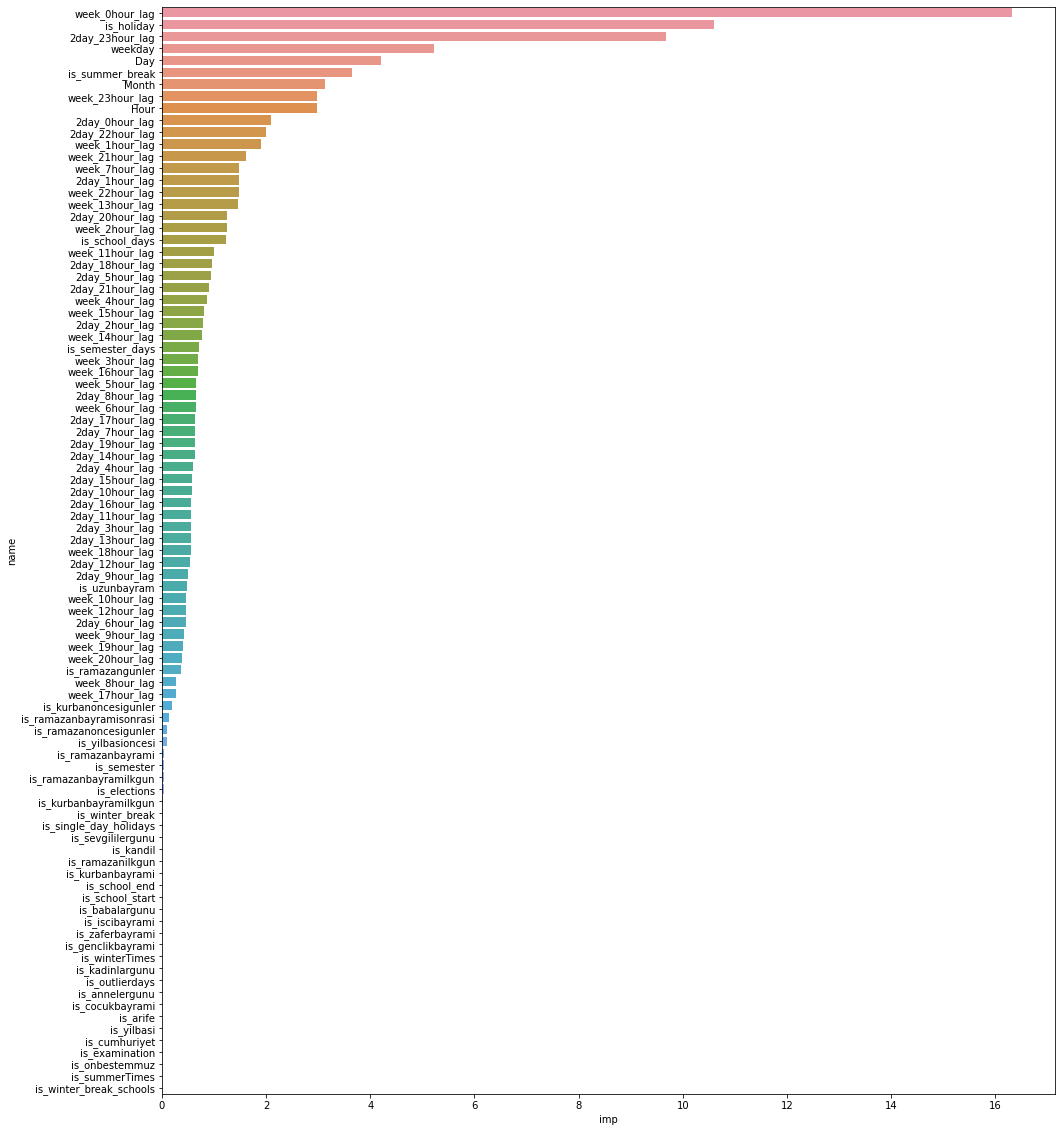

In [0]:
imp_df=pd.DataFrame()
imp_df["imp"]=model.feature_importances_
imp_df["name"]=model.feature_names_
plt.figure(figsize=(16,20))
sns.barplot(x="imp",y="name",data=imp_df.sort_values(by="imp",ascending=False))

RMSE:  1366.3546628534755
RMSLE:  0.04343452637493068
MAE:  897.0144235786686
MAPE:  2.7408498413357565


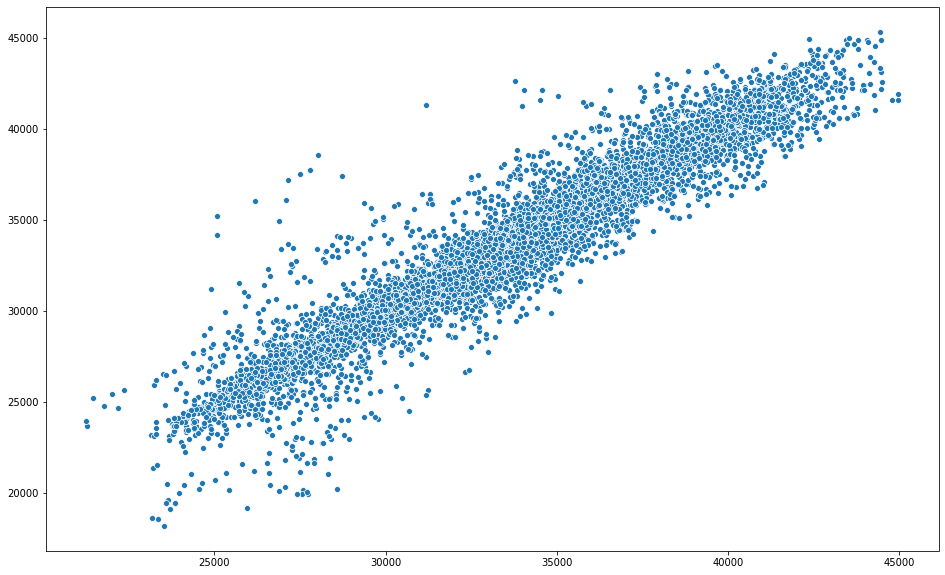

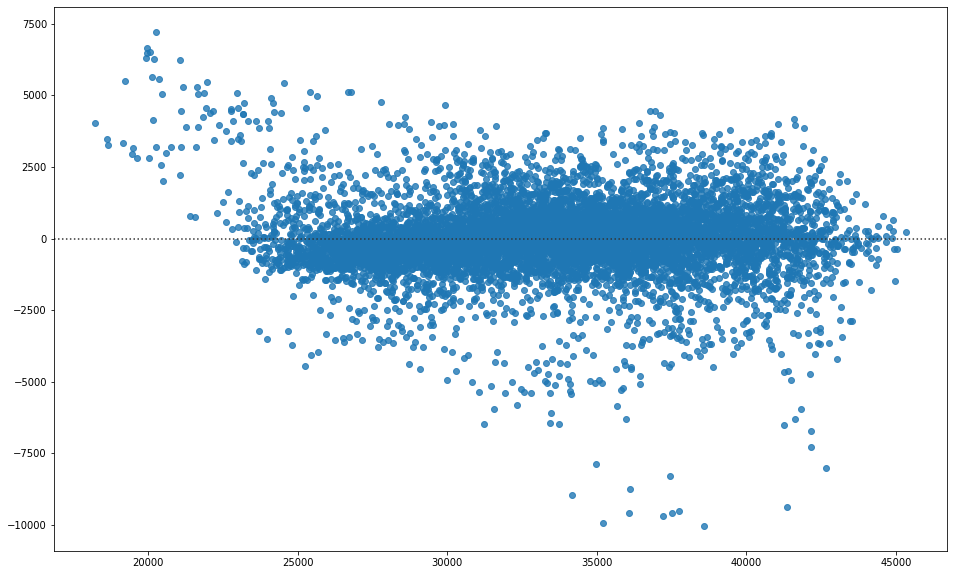

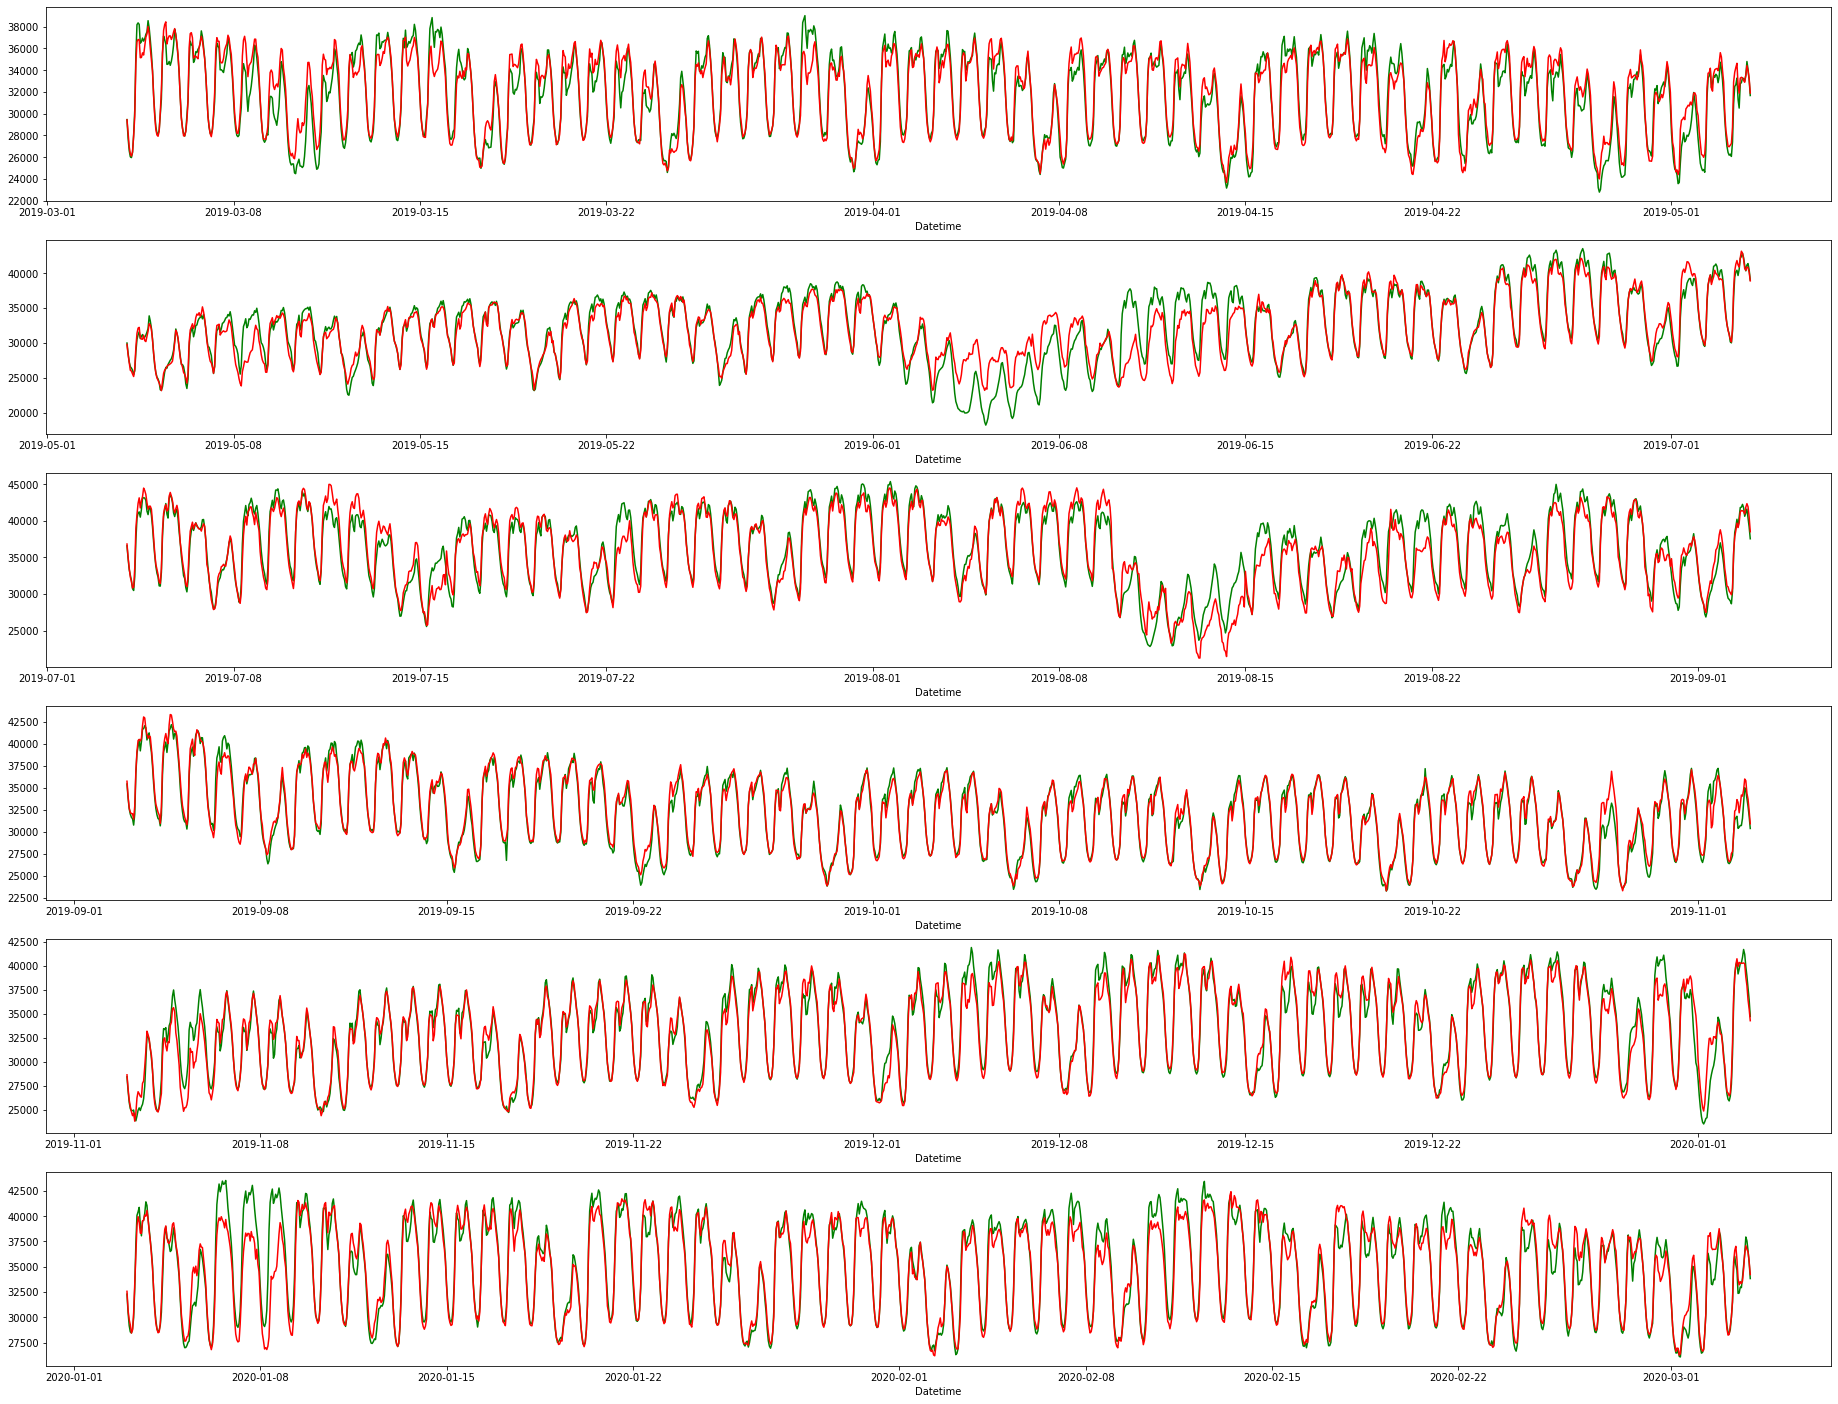

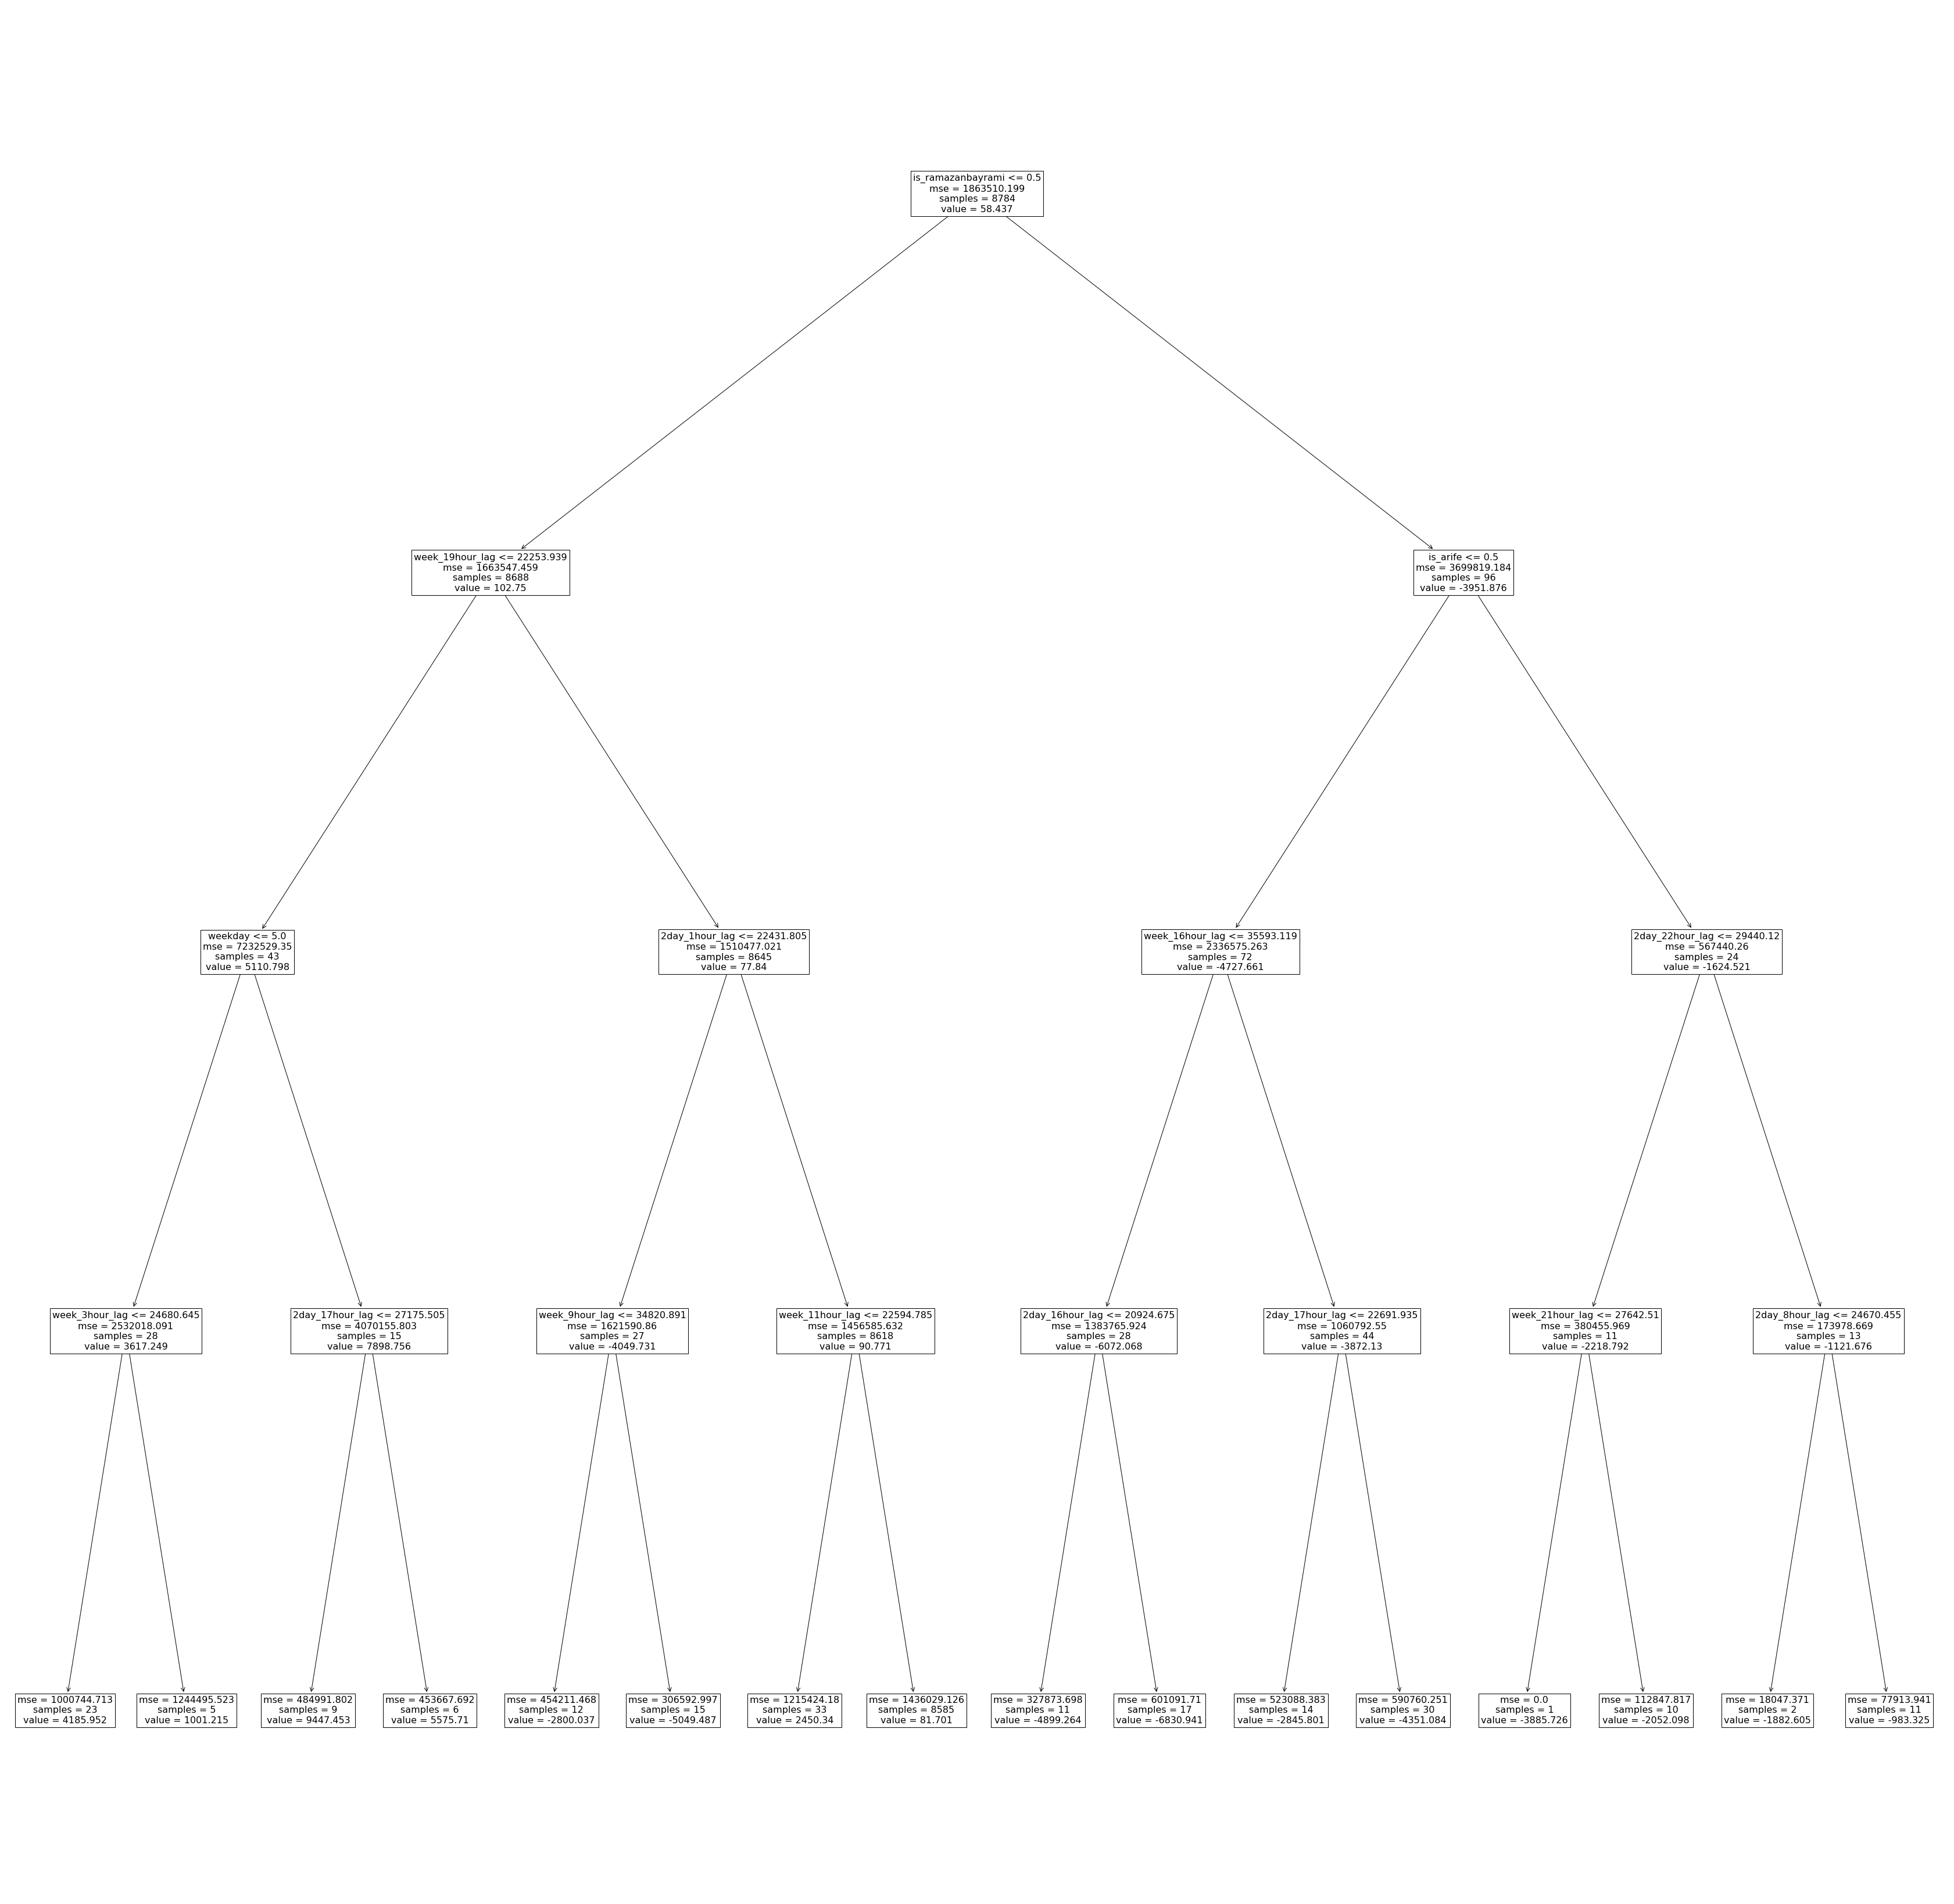

('Cat1',
 1366.3546628534755,
 0.04343452637493068,
 897.0144235786686,
 2.7408498413357565)

In [0]:
y_pred=model.predict(valid_df[needed_colums])
y_true=valid_df["Consumption"].values
eval_function("Cat1",y_true,y_pred,valid_df[needed_colums.tolist()+["Datetime"]])

## CatBoost unholidazasd


In [0]:
# cat_df_1=cons_unholidayized.copy()
# cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
# cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
# cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
# cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)
# cat_df_1["Consumption_2_lag"]=cat_df_1["Consumption"].shift(24*2)
# cat_df_1["Consumption_7_lag"]=cat_df_1["Consumption"].shift(24*7)
# cat_df_1=cat_df_1.dropna()
# cat_df_1.head()


## iki gün oncenin butun datasını alıcam 24 saatin yani
cat_df_1=cons_unholidayized.copy()
cat_df_1["Hour"]=cat_df_1["Hour"].apply(lambda x:x.split(":")[0]).astype(int)
cat_df_1["Day"]=cat_df_1["Date"].apply(lambda x:x.split(".")[0]).astype(int)
cat_df_1["Month"]=cat_df_1["Date"].apply(lambda x:x.split(".")[1]).astype(int)
cat_df_1["weekday"]=pd.to_datetime(cat_df_1["Date"]).apply(lambda x: x.weekday()).astype(int)

# hour lagging
for hour in range(24):
    cat_df_1["2day_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*2-hour)

# week lagging
for hour in range(24):
    cat_df_1["week_{}hour_lag".format(hour)]=cat_df_1["Consumption"].shift(24*7-hour)
cat_df_1=cat_df_1.dropna()
cat_df_1.head()

Date  Hour  ...  week_22hour_lag week_23hour_lag
168  07.01.2016     0  ...     28761.052083    27860.822083
169  07.01.2016     1  ...     27860.822083    32042.050266
170  07.01.2016     2  ...     32042.050266    30756.630266
171  07.01.2016     3  ...     30756.630266    29297.420266
172  07.01.2016     4  ...     29297.420266    28229.590266

[5 rows x 94 columns]

In [0]:
try:
    from catboost import CatBoostRegressor
except ModuleNotFoundError:
    !pip install catboost
    from catboost import CatBoostRegressor

train_df=cat_df_1.loc[cat_df_1["Datetime"]<=pd.to_datetime("2019-03-03 23:00:00")]
valid_df=cat_df_1.loc[cat_df_1["Datetime"]>pd.to_datetime("2019-03-03 23:00:00")]

needed_colums=cat_df_1.columns.difference(["Datetime","Consumption","Date"]+[col for col in cat_df_1.columns if col.startswith("is")])

model = CatBoostRegressor(learning_rate=0.05,
                             num_boost_round=2000,
                             objective="MAE",
                             early_stopping_rounds=300,
                             #task_type="GPU",
                             random_state=1337,
                             depth=12,
                             #bootstrap_type="Poisson",
                             subsample=0.95,
                             max_bin=150)

cat_features_= ["Day","Month","weekday","Hour"]

eval_set=[(valid_df[needed_colums],valid_df["Consumption"])]

model.fit(train_df[needed_colums],train_df["Consumption"],
          eval_set=eval_set,
          cat_features=[needed_colums.tolist().index(i) for i in cat_features_],verbose=2)

0:	learn: 3705.8581996	test: 3656.4267993	best: 3656.4267993 (0)	total: 414ms	remaining: 13m 46s
2:	learn: 3385.6126803	test: 3336.6824088	best: 3336.6824088 (2)	total: 1.22s	remaining: 13m 34s
4:	learn: 3103.5724745	test: 3066.0522023	best: 3066.0522023 (4)	total: 2.04s	remaining: 13m 34s
6:	learn: 2856.0525068	test: 2822.9860440	best: 2822.9860440 (6)	total: 2.83s	remaining: 13m 24s
8:	learn: 2629.1025053	test: 2603.8550838	best: 2603.8550838 (8)	total: 3.62s	remaining: 13m 20s
10:	learn: 2427.6623805	test: 2407.3017093	best: 2407.3017093 (10)	total: 4.42s	remaining: 13m 19s
12:	learn: 2245.2672601	test: 2234.8387319	best: 2234.8387319 (12)	total: 5.21s	remaining: 13m 16s
14:	learn: 2082.6007833	test: 2079.6274518	best: 2079.6274518 (14)	total: 5.99s	remaining: 13m 12s
16:	learn: 1937.9412844	test: 1942.8074730	best: 1942.8074730 (16)	total: 6.78s	remaining: 13m 10s
18:	learn: 1811.0250833	test: 1825.7481734	best: 1825.7481734 (18)	total: 7.59s	remaining: 13m 11s
20:	learn: 1696.2274

RMSE:  2106.3767547837833
RMSLE:  0.06806258746160389
MAE:  1258.8307449477595
MAPE:  4.024073383270438


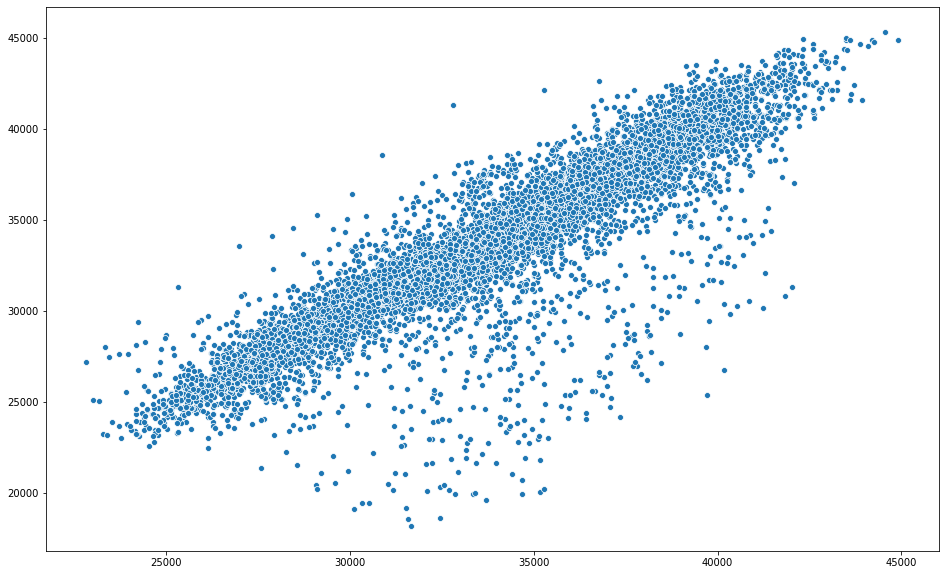

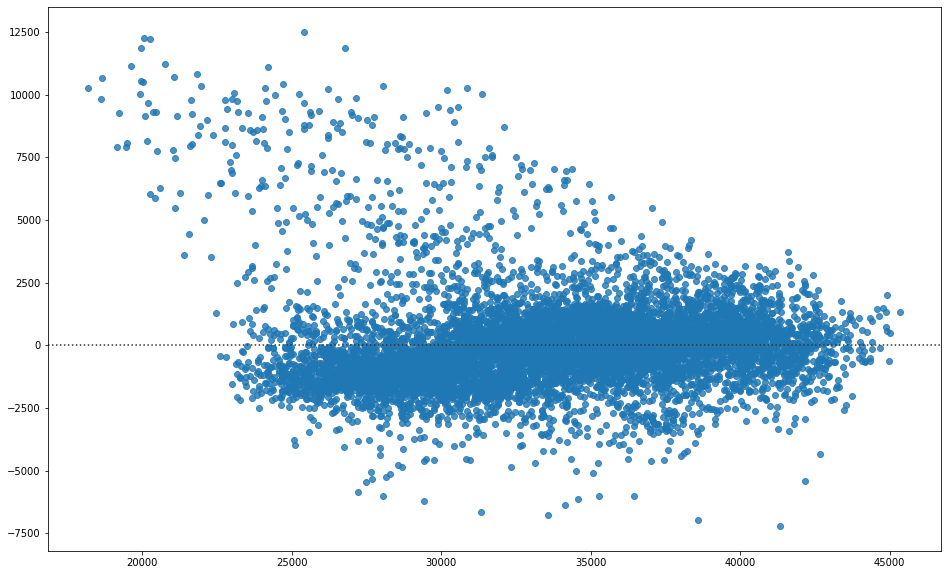

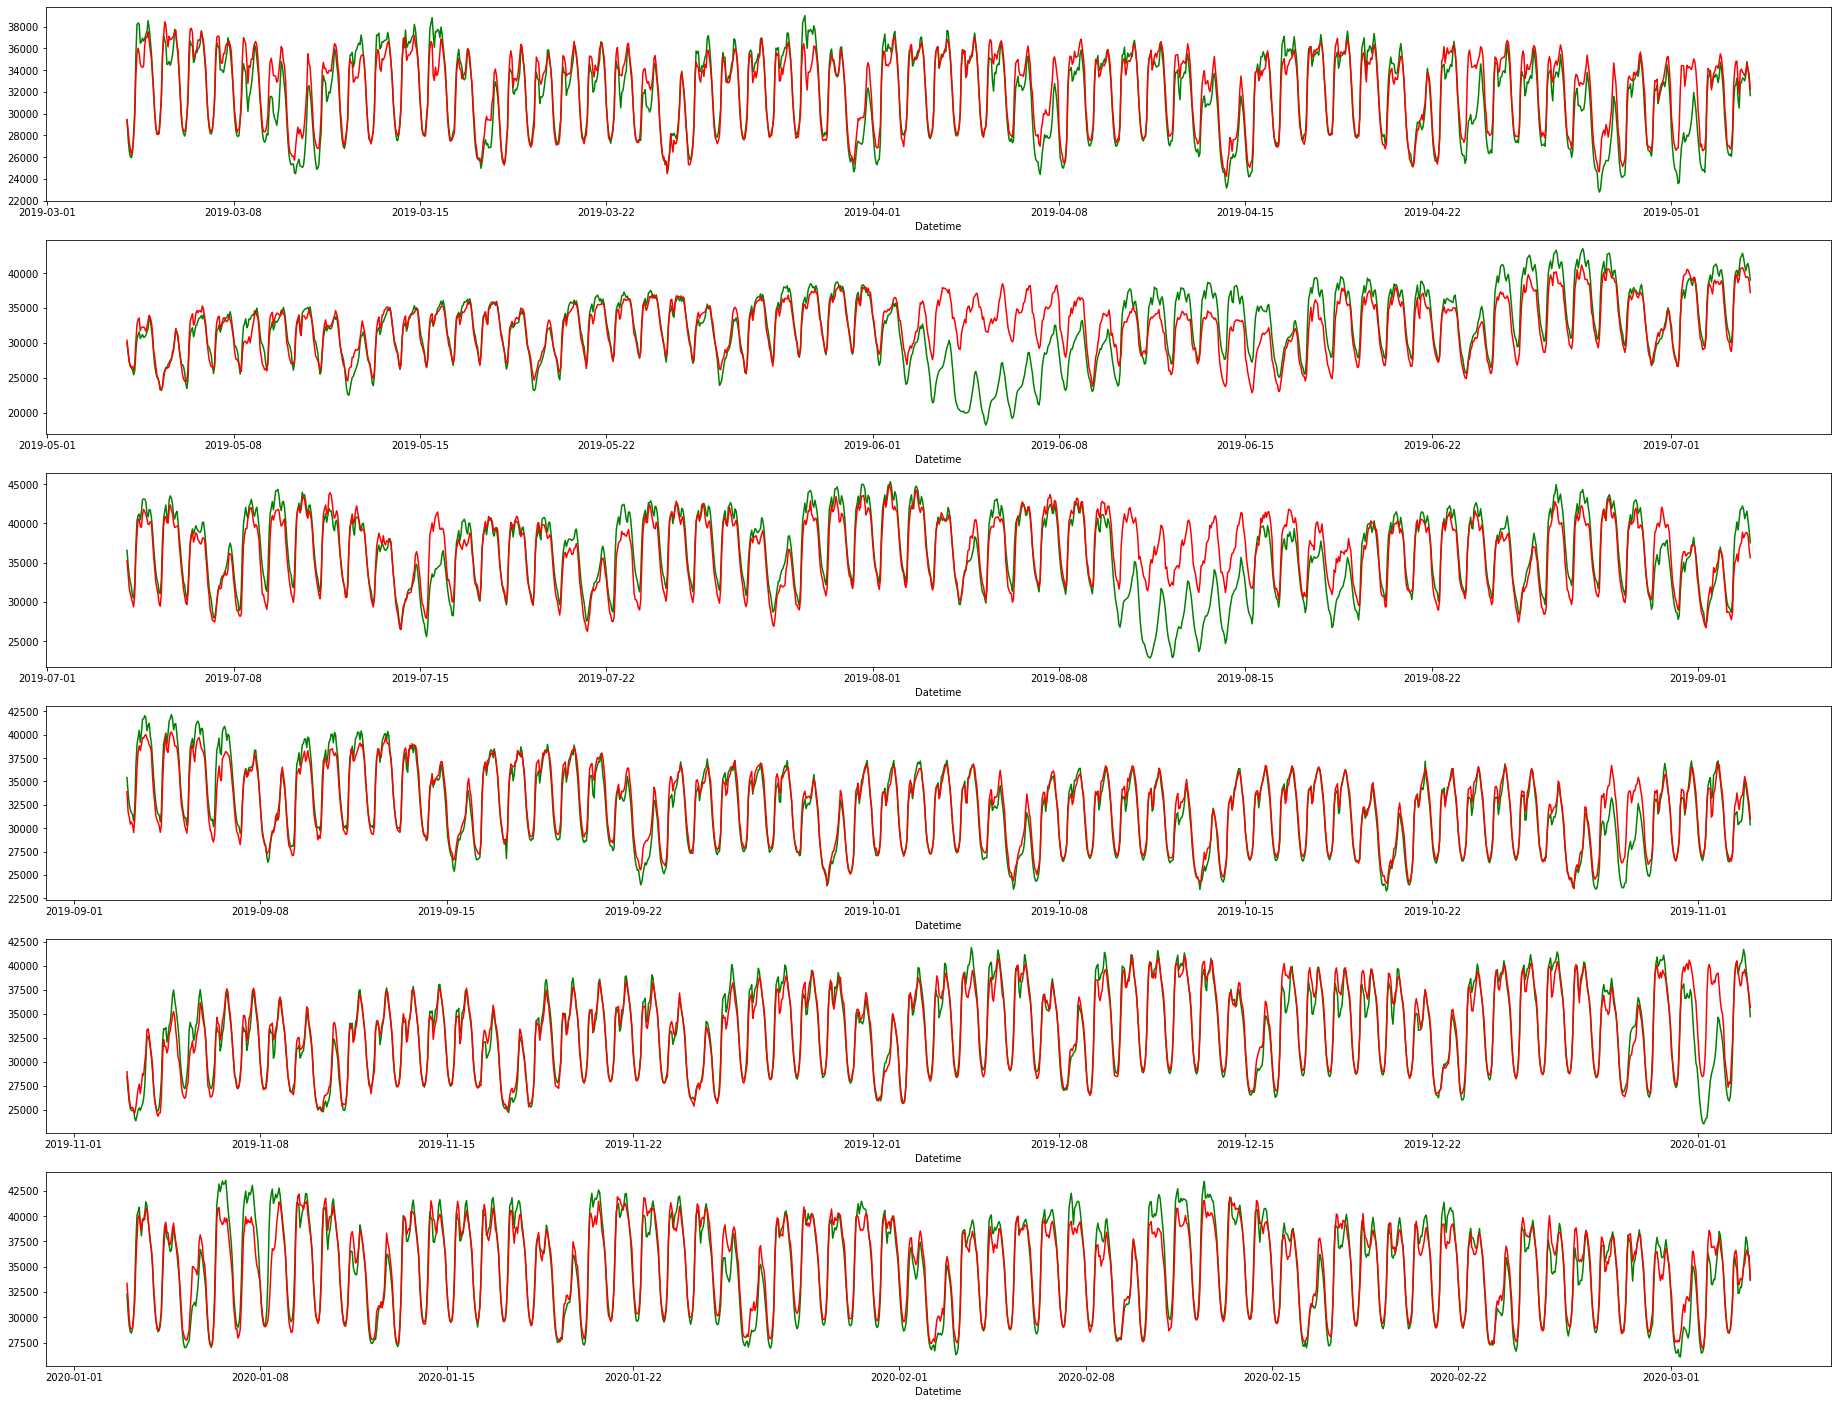

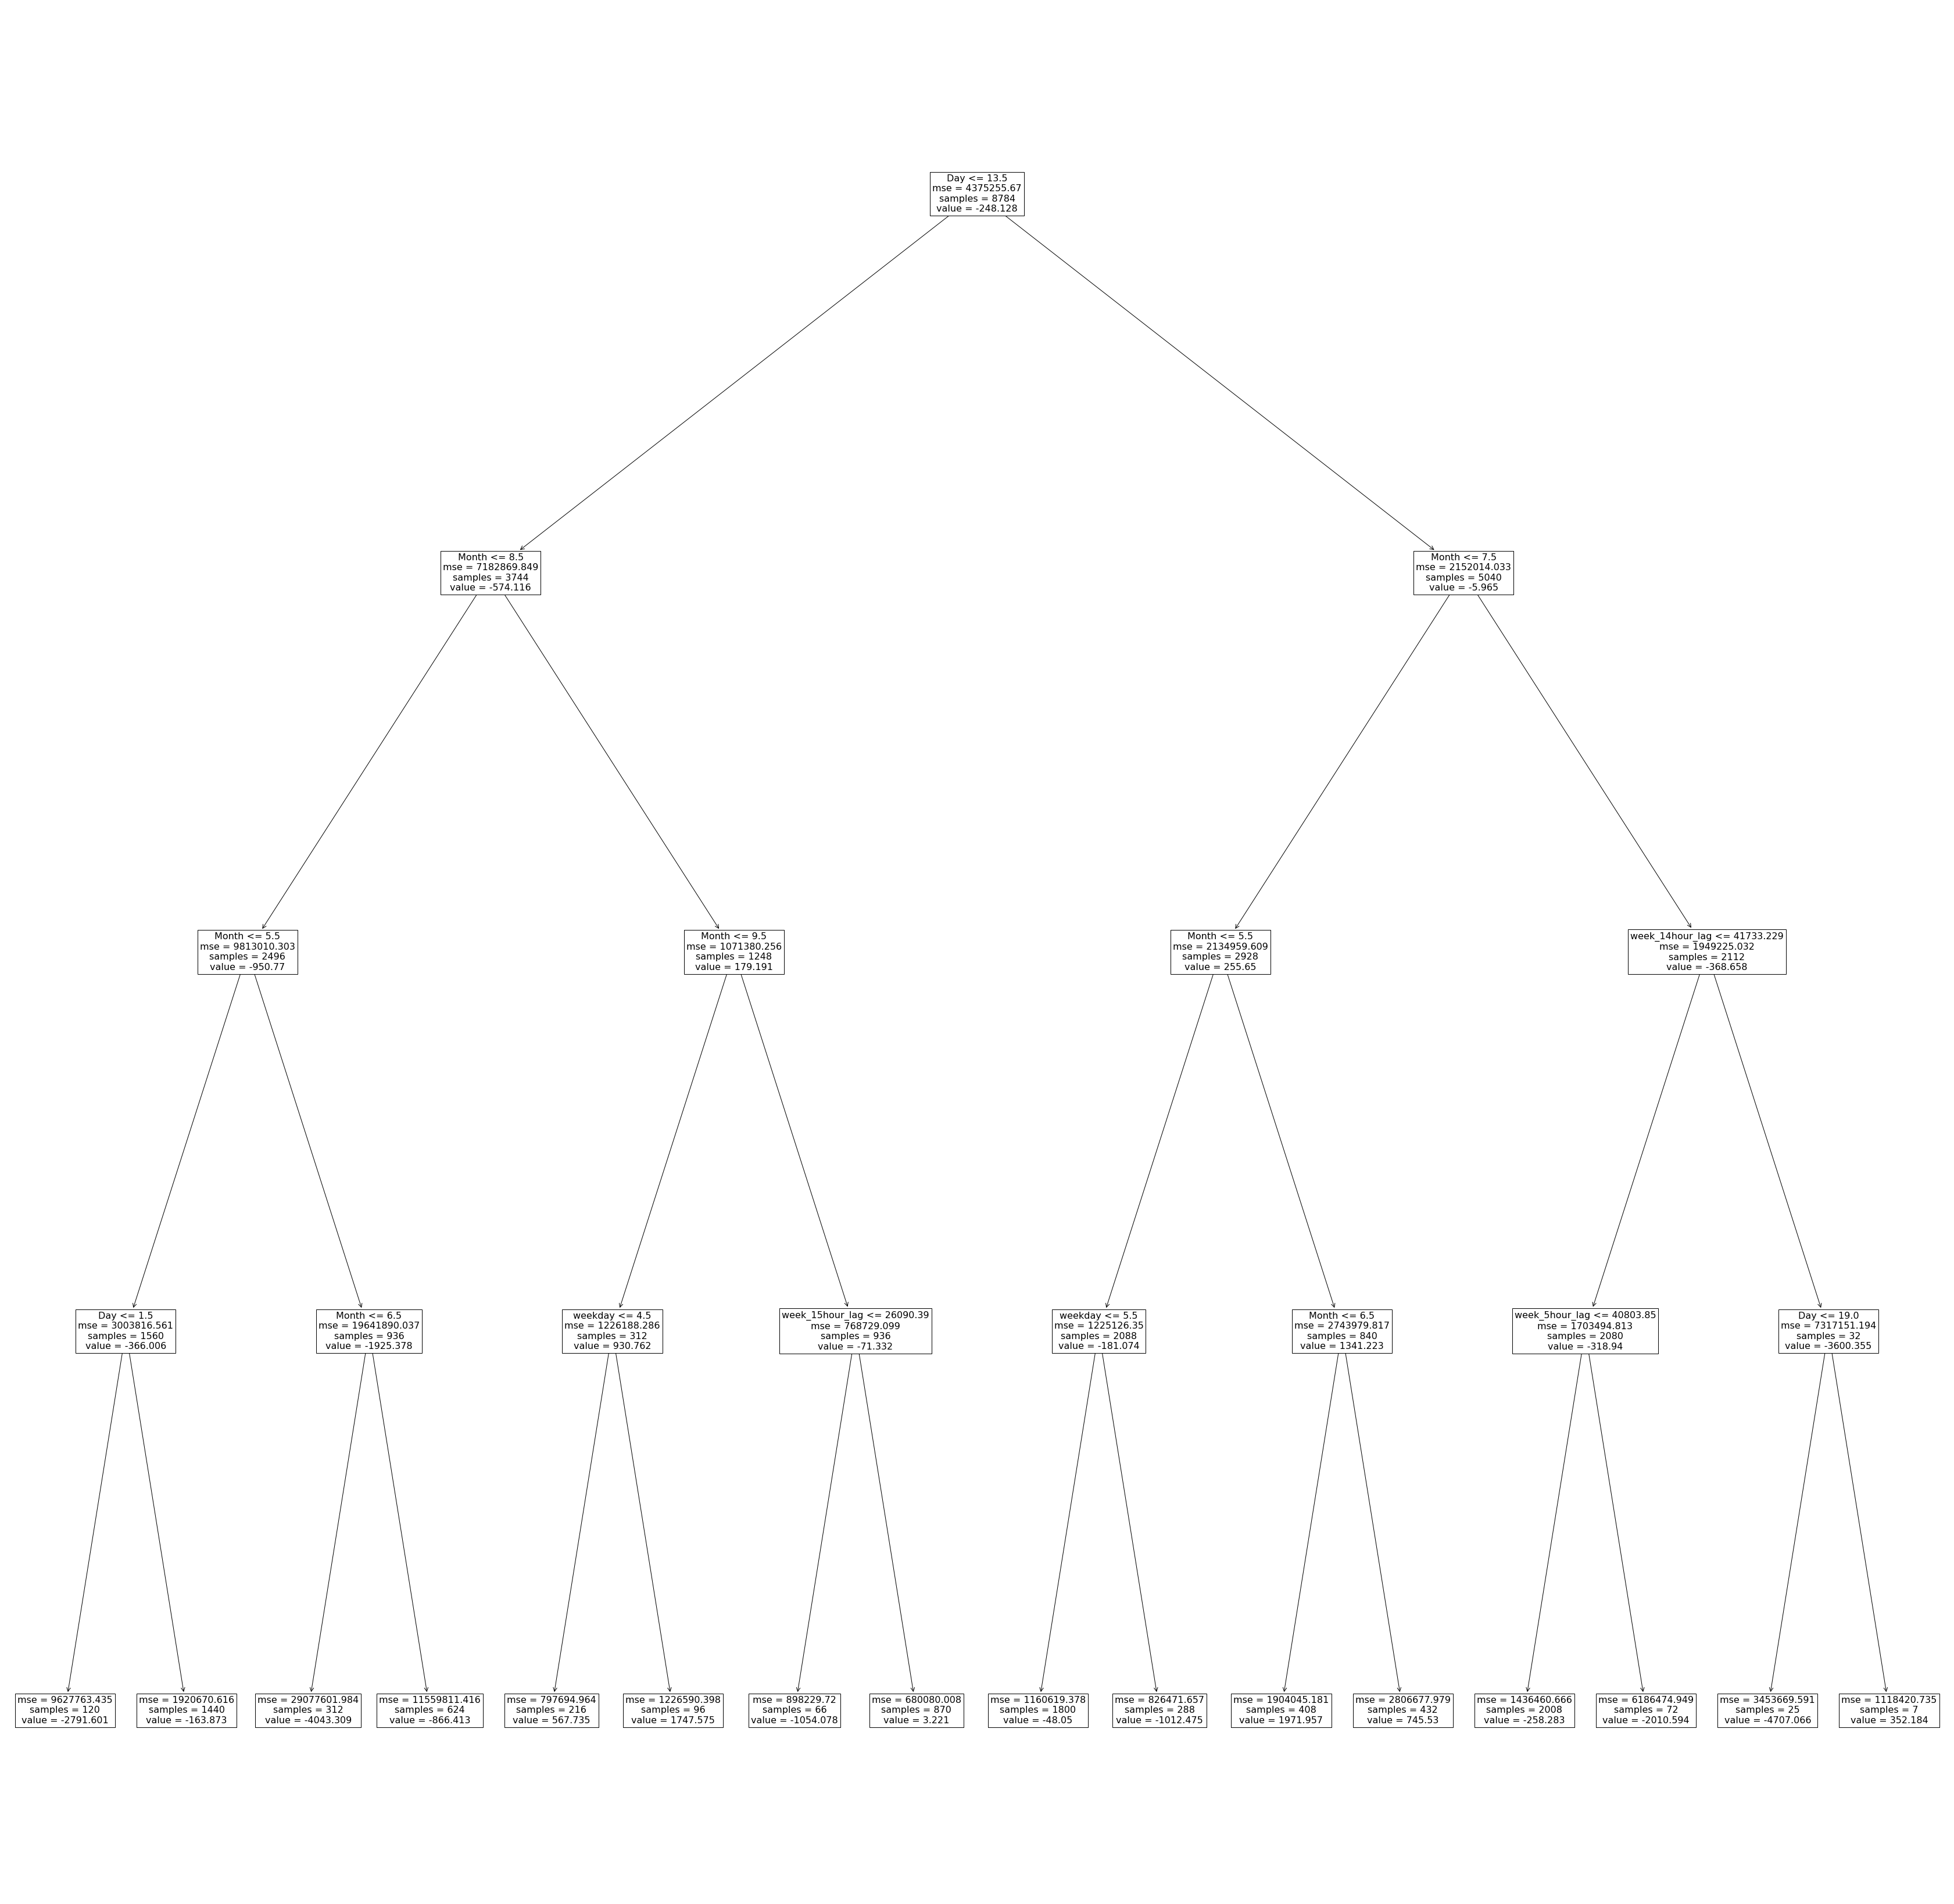

('Cat1',
 2106.3767547837833,
 0.06806258746160389,
 1258.8307449477595,
 4.024073383270438)

In [0]:
y_pred=model.predict(valid_df[needed_colums])
y_true=valid_df["Consumption"]+valid_df[[col for col in cat_df_1.columns if col.startswith("is")]].sum(axis=1)
eval_function("Cat1",y_true.values,y_pred,valid_df[needed_colums.tolist()+["Datetime"]])

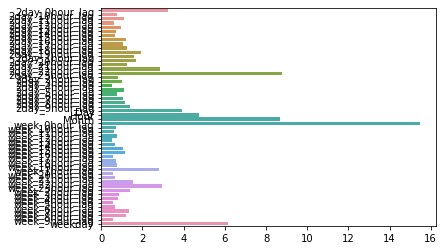

In [0]:
sns.barplot(x=model.feature_importances_,y=model.feature_names_)

# Keras

### Data fix for keras

### modellnig

In [0]:
from keras import backend as K
import keras
from keras.layers import Dense,Input,Conv2D,MaxPooling2D,Activation,Flatten,Dropout,Cropping2D,Lambda,GlobalAveragePooling2D,BatchNormalization,AveragePooling2D
from keras.models import Sequential,Model

In [0]:
# from keras.applications.densenet import DenseNet121, preprocess_input
from keras.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error
from keras.optimizers import Adam, SGD, rmsprop

def root_mean_squared_log_error(y_true, y_pred):
        return K.sqrt(mean_squared_log_error)

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
            EarlyStopping(patience=15, verbose=1),
            ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.00001, verbose=1)
            ]

In [0]:
# basic dense model

from keras.models import Model
from keras.layers import Input, Dense

a = Input(shape=(32,))
b = Dense(32)(a)
model = Model(inputs=a, outputs=b)

In [0]:
## Pretraining with imagenet weights

base_model = DenseNet121(include_top=False, weights='imagenet',
                         input_shape=(SIZE, SIZE, 3), classes=15)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(.2)(x)

predictions = Dense(15, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

## Freeze network except last three layers:

for layer in model.layers:  
    layer.trainable = False

for i in range(-3,0):
    model.layers[i].trainable = True

model.compile(optimizer=Adam(lr=1e-4, decay=1e-9), loss=hn_multilabel_loss, metrics=['binary_crossentropy',
              categorical_crossentropy, categorical_accuracy, top_3_accuracy])


In [0]:
from keras.preprocessing.image import ImageDataGenerator

# Construct the training image generator for data augmentation

aug = ImageDataGenerator(rotation_range = 40,
        width_shift_range = 0.15,
        height_shift_range = 0.15,
        shear_range = 0.15,
        zoom_range = 0.2,  
        horizontal_flip = True,
        vertical_flip = False,
        fill_mode ='nearest')
        
aug_val = ImageDataGenerator()

# Train the network

H = model.fit_generator(aug.flow(x_train, y_train, batch_size=BS),
                        validation_data = aug_val.flow(x_test, y_test, batch_size=BS) , 
                        validation_steps = (len(df_feature)//TEST_SIZE )// BS,
                        callbacks = callbacks, 
                        steps_per_epoch = len(df_feature) // BS,
                        epochs = 5)